# 0. Постановка задачи
Предсказываем банкротство польских компаний по 64 финансовым коэффициентам из набора данных Kaggle "Predict Bankruptcy in Poland". Целевая переменная class:

- 0 — компания продолжает работу;
- 1 — компания обанкротилась.
- Это задача бинарной классификации с сильным дисбалансом классов.

# 1. Загрузка данных

Используем файл archive/data.csv, где каждая строка — компания в конкретный год до возможного банкротства. Считаем таблицу, посмотрим на размерность и первые строки.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline

DATA_PATH = Path('archive/data.csv')
data_raw = pd.read_csv(DATA_PATH)

print('Размеры набора данных:', data_raw.shape)
display(data_raw.head())
data_raw.info()

Размеры набора данных: (43405, 66)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A57,A58,A59,A60,A61,A62,A63,A64,class,year
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0,1
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0,1
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0,1
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0,1
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      43397 non-null  float64
 1   A2      43397 non-null  float64
 2   A3      43397 non-null  float64
 3   A4      43271 non-null  float64
 4   A5      43316 non-null  float64
 5   A6      43397 non-null  float64
 6   A7      43397 non-null  float64
 7   A8      43311 non-null  float64
 8   A9      43396 non-null  float64
 9   A10     43397 non-null  float64
 10  A11     43361 non-null  float64
 11  A12     43271 non-null  float64
 12  A13     43278 non-null  float64
 13  A14     43397 non-null  float64
 14  A15     43369 non-null  float64
 15  A16     43310 non-null  float64
 16  A17     43311 non-null  float64
 17  A18     43397 non-null  float64
 18  A19     43277 non-null  float64
 19  A20     43278 non-null  float64
 20  A21     37551 non-null  float64
 21  A22     43397 non-null  float64
 22

# 2. Разведочный анализ (EDA)

Смотрим распределения числовых признаков, доли классов, пропуски и корреляции, чтобы понимать структуру данных перед моделированием.


In [9]:
# Числовые признаки:
num_summary = data_raw.describe().T
num_summary.head()


,count,mean,std,min,25%,50%,75%,max
A1,43397.0,0.035160,2.994109,-4.638900e+02,0.003429,0.04966,0.12958,94.280
A2,43397.0,0.590212,5.842748,-4.308700e+02,0.268980,0.47190,0.68832,480.960
A3,43397.0,0.114431,5.439429,-4.799600e+02,0.021521,0.19661,0.40339,28.336
A4,43271.0,6.314702,295.434425,-4.031100e-01,1.049500,1.56980,2.78745,53433.000
A5,43316.0,-385.346602,61243.025874,-1.190300e+07,-49.080000,-1.03450,50.63425,1250100.000


Абсолютные значения:
 class
0    41314
1     2091
Name: count, dtype: int64

Доли классов:
 class
0    0.951826
1    0.048174
Name: proportion, dtype: float64


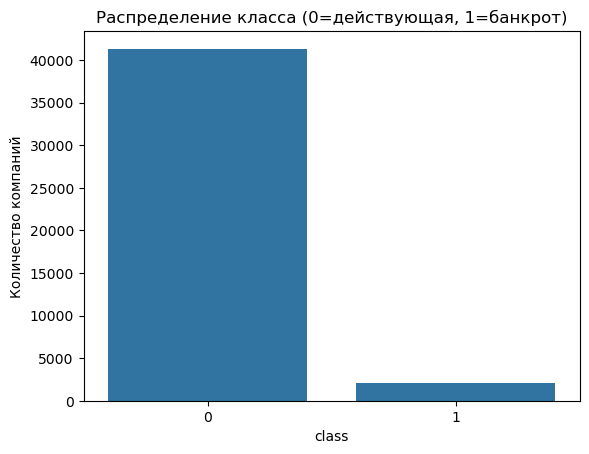

In [10]:
# Баланс классов 
class_counts = data_raw['class'].value_counts()
class_share = data_raw['class'].value_counts(normalize=True)
print('Абсолютные значения:\n', class_counts)
print('\nДоли классов:\n', class_share)

sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title('Распределение класса (0=действующая, 1=банкрот)')
plt.ylabel('Количество компаний')
plt.show()


In [11]:
# Пропущенные значения: считаем абсолютные и относительные
missing = data_raw.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(data_raw) * 100).round(2)
missing_summary = pd.DataFrame({'missing': missing, 'missing_%': missing_pct})
missing_summary.head(10)


,missing,missing_%
A37,18984,43.74
A21,5854,13.49
A27,2764,6.37
A60,2152,4.96
A45,2147,4.95
A24,922,2.12
A64,812,1.87
A53,812,1.87
A54,812,1.87
A28,812,1.87


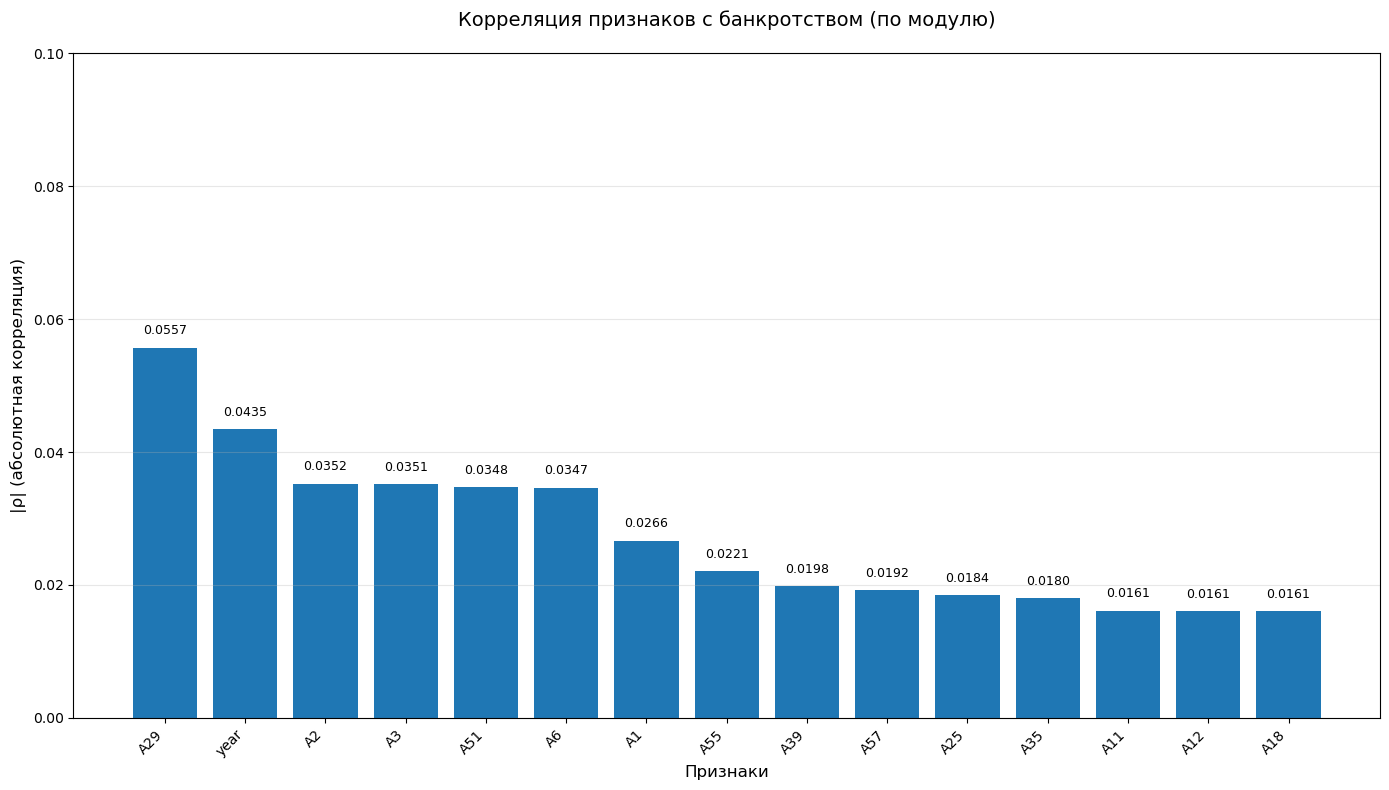

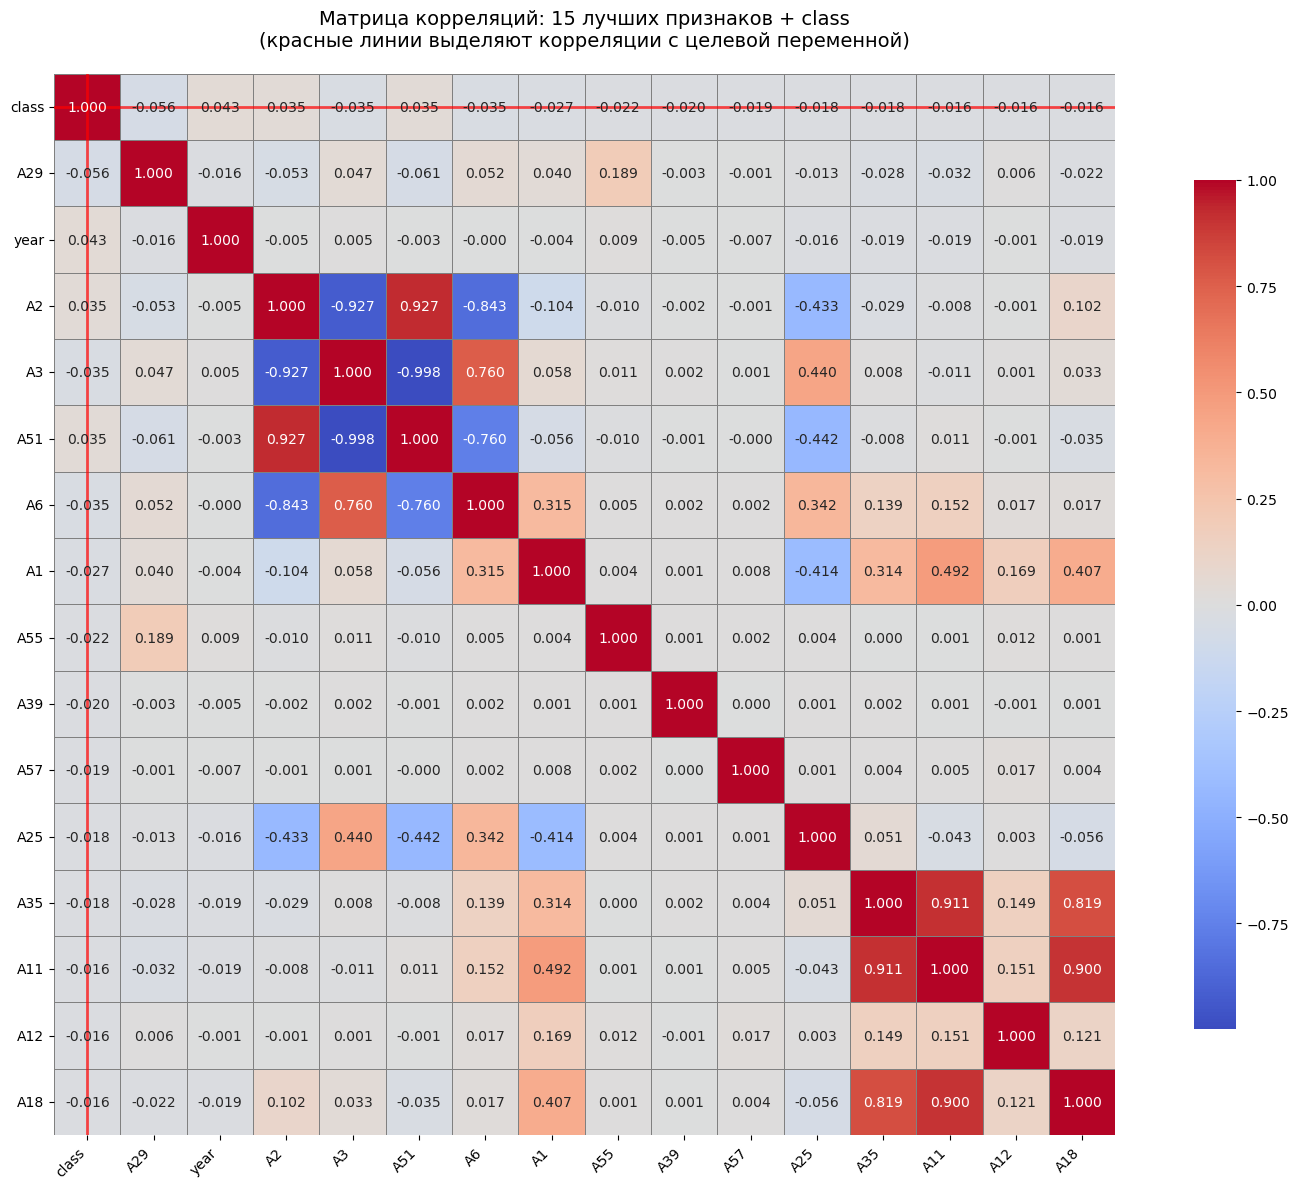

Топ-16 признаков по корреляции с банкротством (включая сам class):
class    1.000000
A29      0.055717
year     0.043488
A2       0.035236
A3       0.035128
A51      0.034753
A6       0.034662
A1       0.026649
A55      0.022101
A39      0.019850
A57      0.019204
A25      0.018415
A35      0.018003
A11      0.016147
A12      0.016108
A18      0.016053
Name: class, dtype: float64


In [12]:
# Матрица корреляций 
corr_with_class = data_raw.corr()['class'].abs().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
top_features = corr_with_class.index[1:16]  # Исключаем сам class
bars = plt.bar(top_features, corr_with_class[top_features])

plt.title('Корреляция признаков с банкротством (по модулю)', fontsize=14, pad=20)
plt.xlabel('Признаки', fontsize=12)
plt.ylabel('|ρ| (абсолютная корреляция)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 0.1)

for bar, value in zip(bars, corr_with_class[top_features]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{value:.4f}', ha='center', fontsize=9)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

top_15_with_class = list(corr_with_class.index[:16])

plt.figure(figsize=(16, 12))
corr_matrix = data_raw[top_15_with_class].corr()

sns.heatmap(corr_matrix, 
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            center=0,
            square=True,
            cbar_kws={'shrink': 0.8},
            linewidths=0.5,
            linecolor='gray')

plt.axhline(y=top_15_with_class.index('class')+0.5, color='red', linewidth=2, alpha=0.7)
plt.axvline(x=top_15_with_class.index('class')+0.5, color='red', linewidth=2, alpha=0.7)

plt.title('Матрица корреляций: 15 лучших признаков + class\n(красные линии выделяют корреляции с целевой переменной)', 
          fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Топ-16 признаков по корреляции с банкротством (включая сам class):")
print(corr_with_class.head(16))

 Наблюдения по EDA:
- Все 66 столбцов числовые; большинство имеют пропуски <5%, но есть признаки с существенными пропусками (например, `A37`).
- Дисбаланс классов выраженный: банкроты составляют ~5% выборки — позже применим балансировку.
- Корреляции показывают, что признаки из группы `A29`, `year`, `A2`, `A3`, `A51` сильнее всего связаны с целевой переменной; часть коэффициентов сильно коррелирует друг с другом, поэтому позже удалим дубли.


# 3. Обработка пропусков

Все признаки числовые, поэтому заполним пропуски медианами — это нужно, чтобы kNN и другие модели корректно обучались.


In [14]:
from sklearn.impute import SimpleImputer

cols_to_drop = ['A37']
data_model = data_raw.drop(columns=cols_to_drop)
print('Удаляем признаки с большим числом пропусков:', cols_to_drop)

data_filtered = data_model.copy()
feature_cols = [col for col in data_filtered.columns if col != 'class']
X = data_filtered[feature_cols].copy()
y = data_filtered['class'].copy()

num_imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(num_imputer.fit_transform(X), columns=feature_cols)

#print(f'Удалено признаков: {len(features_to_drop)}')
print('Количество пропусков после заполнения:', X_imputed.isna().sum().sum())
print(f'Новая размерность данных: {X_imputed.shape}')


Удаляем признаки с большим числом пропусков: ['A37']
Количество пропусков после заполнения: 0
Новая размерность данных: (43405, 64)


# 4. Обработка категориальных признаков

В отличие от примера `12-6` с квартирами, где были признаки `Type` и `Building`, этот набор содержит только числовые коэффициенты `A1`-`A64` и признак `year`. Поэтому дополнительных преобразований не требуется просто фиксируем это явно.


# 5. Нормализация признаков

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=feature_cols)
X_scaled.head()


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A56,A57,A58,A59,A60,A61,A62,A63,A64,year
0,0.055243,-0.036062,0.051842,-0.014418,0.006815,0.061710,0.027359,-0.022332,-0.024044,-0.008310,...,0.004937,0.029816,-0.005459,-0.010903,-0.013254,-0.021491,-0.010179,-0.039635,-0.027302,-1.510758
1,0.058106,-0.015458,0.065787,-0.014765,0.006527,0.007791,0.028861,-0.022994,-0.015133,-0.008792,...,0.004937,0.031487,-0.005464,-0.010918,-0.013389,-0.024866,-0.010001,-0.047828,-0.004482,-1.510758
2,0.071313,0.018098,0.028073,-0.016087,0.006267,0.007791,0.037740,-0.024100,-0.021341,-0.022003,...,0.004959,0.060575,-0.005480,-0.005227,-0.013363,-0.023639,-0.009808,-0.053325,-0.028248,-1.510758
3,0.015472,-0.048415,0.063312,-0.012907,0.007135,0.028606,-0.000134,-0.021272,-0.025344,-0.003635,...,0.004924,0.011158,-0.005446,-0.010918,-0.013376,-0.024247,-0.010152,-0.041192,-0.028102,-1.510758
4,0.050824,0.003944,0.021172,-0.016590,0.006166,0.033805,0.016429,-0.023717,-0.023774,-0.016366,...,0.004939,0.036189,-0.005461,-0.009899,-0.013318,-0.022978,-0.009858,-0.052109,-0.027102,-1.510758


Теперь все признаки с нулевым средним и единичным стандартным отклонением — можно переходить к разбиению на train/test и настройке моделей.


Категориальных признаков нет (все столбцы числовые коэффициенты), поэтому one-hot кодирование не требуется.


# 6. Разбиение на обучающую и тестовую выборки

Разделяем данные на train/test (80/20) с сохранением долей классов (`stratify=y`).


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)
print('Доля класса 1 в train:', y_train.mean().round(4))
print('Доля класса 1 в test:', y_test.mean().round(4))


Train shape: (34724, 64)
Test shape: (8681, 64)
Доля класса 1 в train: 0.0482
Доля класса 1 в test: 0.0482


# 7. Базовый классификатор k ближайших соседей(kNN)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)
y_proba_knn = knn_pipeline.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred_knn)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_knn, average='binary')
roc_auc = roc_auc_score(y_test, y_proba_knn)

print(f"Базовый kNN (k=5): accuracy={acc:.3f}, precision={precision:.3f}, recall={recall:.3f}, F1={f1:.3f}, ROC-AUC={roc_auc:.3f}")


Базовый kNN (k=5): accuracy=0.949, precision=0.245, recall=0.031, F1=0.055, ROC-AUC=0.597


## 8. Подбор оптимального числа соседей

Используем `GridSearchCV` по нечётным значениям `k` (3–31) и максимальным соседям, оптимизируем `f1`.


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'knn__n_neighbors': list(range(3, 32, 2))}
grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
print('Лучший k:', grid_search.best_params_)
print('Лучший F1 (CV):', grid_search.best_score_.round(3))


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Лучший k: {'knn__n_neighbors': 3}
Лучший F1 (CV): 0.094


# 9. Оценка качества на обучении и тесте

Берём лучший kNN из поиска и сравниваем ошибки/метрики на train и test. Используем accuracy, precision, recall, F1 и ROC-AUC.


In [19]:
best_knn = grid_search.best_estimator_
y_pred_train = best_knn.predict(X_train)
y_pred_test = best_knn.predict(X_test)
y_proba_train = best_knn.predict_proba(X_train)[:, 1]
y_proba_test = best_knn.predict_proba(X_test)[:, 1]

def print_metrics(y_true, y_pred, y_proba, label):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_proba)
    print(f"{label}: accuracy={acc:.3f}, precision={precision:.3f}, recall={recall:.3f}, F1={f1:.3f}, ROC-AUC={roc_auc:.3f}")

print_metrics(y_train, y_pred_train, y_proba_train, 'Train')
print_metrics(y_test, y_pred_test, y_proba_test, 'Test')


Train: accuracy=0.959, precision=0.751, recall=0.213, F1=0.332, ROC-AUC=0.967
Test: accuracy=0.945, precision=0.223, recall=0.060, F1=0.094, ROC-AUC=0.571


# 10. Другие классификаторы и подбор параметров

Для сравнения пробуем логистическую регрессию (с регуляризацией `C`) и случайный лес (параметры `n_estimators`, `max_depth`).


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

rf_pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

logreg_grid = {'clf__C': [0.01, 0.1, 1, 10], 'clf__class_weight': [None]}
rf_grid = {'clf__n_estimators': [200, 400], 'clf__max_depth': [None, 10, 20]}

logreg_search = GridSearchCV(logreg_pipeline, logreg_grid, scoring='f1', cv=5, n_jobs=-1)
rf_search = GridSearchCV(rf_pipeline, rf_grid, scoring='f1', cv=5, n_jobs=-1)

logreg_search.fit(X_train, y_train)
rf_search.fit(X_train, y_train)

print('Best LogisticRegression params:', logreg_search.best_params_, 'F1:', round(logreg_search.best_score_, 3))
print('Best RandomForest params:', rf_search.best_params_, 'F1:', round(rf_search.best_score_, 3))


Best LogisticRegression params: {'clf__C': 10, 'clf__class_weight': None} F1: 0.025
Best RandomForest params: {'clf__max_depth': 20, 'clf__n_estimators': 200} F1: 0.381


In [21]:
models = {
    'kNN_best': best_knn,
    'LogReg': logreg_search.best_estimator_,
    'RandomForest': rf_search.best_estimator_
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_proba)
    results.append({'model': name, 'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc})

pd.DataFrame(results).round(3)


,model,accuracy,precision,recall,f1,roc_auc
0,kNN_best,0.945,0.223,0.060,0.094,0.571
1,LogReg,0.951,0.300,0.007,0.014,0.675
2,RandomForest,0.963,0.888,0.266,0.409,0.925


# 11. Борьба с дисбалансом классов

Класс 1 составляет ~5% данных, поэтому precision/recall падают. Как минимум два подхода: (1) использовать веса классов, (2) увеличить число объектов редкого класса (oversampling). Покажем, как простое oversampling улучшает полноту.


In [22]:
from sklearn.utils import resample
from sklearn.base import clone

train_df = X_train.copy()
train_df['class'] = y_train.values
majority = train_df[train_df['class'] == 0]
minority = train_df[train_df['class'] == 1]

minority_up = resample(minority, replace=True, n_samples=len(majority), random_state=42)
train_balanced = pd.concat([majority, minority_up]).sample(frac=1, random_state=42)

X_train_bal = train_balanced.drop(columns='class')
y_train_bal = train_balanced['class']

balanced_logreg = clone(logreg_search.best_estimator_)
balanced_logreg.fit(X_train_bal, y_train_bal)

y_pred_bal = balanced_logreg.predict(X_test)
y_proba_bal = balanced_logreg.predict_proba(X_test)[:, 1]
print_metrics(y_test, y_pred_bal, y_proba_bal, 'Test (LogReg + oversampling)')


Test (LogReg + oversampling): accuracy=0.731, precision=0.106, recall=0.617, F1=0.181, ROC-AUC=0.741


# 12. Исключение сильно коррелированных признаков

Как отмечалось в EDA, многие коэффициенты линейно связаны. Высокая корреляция ухудшает интерпретацию и может мешать линейным моделям. Удаляем признаки с |corr| > 0.95 (по верхнему треугольнику корреляционной матрицы).


In [24]:
corr_matrix = X_imputed.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
features_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print('Сильно коррелирующих признаков:', len(features_to_drop))
X_reduced = X_imputed.drop(columns=features_to_drop)

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

logreg_reduced = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_reduced.fit(X_train_red, y_train_red)
y_pred_red = logreg_reduced.predict(X_test_red)
y_proba_red = logreg_reduced.predict_proba(X_test_red)[:, 1]
print_metrics(y_test_red, y_pred_red, y_proba_red, 'LogReg на урезанном наборе')


Сильно коррелирующих признаков: 21
LogReg на урезанном наборе: accuracy=0.952, precision=0.400, recall=0.005, F1=0.009, ROC-AUC=0.620


Exception ignored in: <function ResourceTracker.__del__ at 0x76e4ddd92c00>
Traceback (most recent call last):
  File "/home/linuxoid/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/linuxoid/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/linuxoid/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x71e18cb86c00>
Traceback (most recent call last):
  File "/home/linuxoid/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/linuxoid/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/linuxoid/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function Resour

# 13. Общие выводы

- Базовый kNN без настройки показал умеренные метрики; тюнинг `k` дал небольшой прирост, но чувствителен к дисбалансу.
- Логистическая регрессия и случайный лес дали сопоставимое или лучшее качество; oversampling заметно поднял recall/F1.
- Исключение сильно коррелирующих признаков упрощает модель и почти не ухудшает качество.

